## Processing Ocean Color Imagery

Basic goal of this notebook is to test out the full workflow and find the ideal viewing geometry. These flights took place around 9:30 LST 13:30 UTC.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import pandas as pd


import os, glob
import multiprocessing

import cv2
import numpy as np
import matplotlib.pyplot as plt

import exiftool
import datetime

import rasterio

# local functions
from utils import *
from georeg import *

In [3]:
! ls data/20210407_duml_full_workflow_test/

all_imgs       sea	    sky_rededge
panel	       sea_rededge  sunblocked_rededge
panel_rededge  sky	    SYNLog-13-24-55_07-04-2021.csv


In [4]:
alta_logs = format_alta_logs('data/20210407_duml_full_workflow_test/SYNLog-13-24-55_07-04-2021.csv')
alta_logs.head()

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (0,1,2,4,5,6,7,9) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Reading IMU Time      Date  GPS Time Unnamed: 4  \
dt                                                                           
2021-04-07 13:24:55.000000      41      1.6  20210407  13:24:55        NaN   
2021-04-07 13:24:55.000001      42     1.64  20210407  13:24:55        NaN   
2021-04-07 13:24:55.000002      43     1.68  20210407  13:24:55        NaN   
2021-04-07 13:24:55.000003      44     1.72  20210407  13:24:55        NaN   
2021-04-07 13:24:55.000004      45     1.76  20210407  13:24:55        NaN   

                             Longitude   Latitude GPS Height  GPS Course  \
dt                                                                         
2021-04-07 13:24:55.000000  -766726976  347156896       1.27        18.5   
2021-04-07 13:24:55.000001  -766726976  347156896       1.27        18.5   
2021-04-07 13:24:55.000002  -766726976  347156896       1.27        18.5   
2021-04-07 13:24:55.000003  -766726976  347156896       1.27        18.5   
2021-04-07 13:24:55.000004  -766726976  347156896       1.27        18.5   

                           GPS Pos N  ...  Gyro Bias P  Gyro Bias Y  \
dt                                    ...                             
2021-04-07 13:24:55.000000     -6.43  ...     -39.3661       6.5308   
2021-04-07 13:24:55.000001     -6.43  ...     -39.3580       6.5309   
2021-04-07 13:24:55.000002     -6.43  ...     -39.3630       6.5349   
2021-04-07 13:24:55.000003     -6.43  ...     -39.3628       6.5372   
2021-04-07 13:24:55.000004     -6.43  ...     -39.3647       6.5371   

                            Accel Bias X  Accel Bias Y  Accel Bias Z  \
dt                                                                     
2021-04-07 13:24:55.000000        -0.004         0.001         0.272   
2021-04-07 13:24:55.000001        -0.004         0.001         0.272   
2021-04-07 13:24:55.000002        -0.004         0.001         0.272   
2021-04-07 13:24:55.000003        -0.004         0.000         0.273   
2021-04-07 13:24:55.000004        -0.005         0.000         0.273   

                            Extended Status  5V Alarm  Z Vibration  Checksum  \
dt                                                                             
2021-04-07 13:24:55.000000              0.0       0.0         0.04     239.0   
2021-04-07 13:24:55.000001              0.0       0.0         0.03     110.0   
2021-04-07 13:24:55.000002              0.0       0.0         0.03     138.0   
2021-04-07 13:24:55.000003              0.0       0.0         0.03      50.0   
2021-04-07 13:24:55.000004              0.0       0.0         0.03     234.0   

                            id  
dt                              
2021-04-07 13:24:55.000000   0  
2021-04-07 13:24:55.000001   1  
2021-04-07 13:24:55.000002   2  
2021-04-07 13:24:55.000003   3  
2021-04-07 13:24:55.000004   4  

[5 rows x 174 columns]

In [5]:
! ls data/20210407_duml_full_workflow_test/

all_imgs       sea	    sky_rededge
panel	       sea_rededge  sunblocked_rededge
panel_rededge  sky	    SYNLog-13-24-55_07-04-2021.csv


In [6]:
sky_dir = os.path.join('data', '20210407_duml_full_workflow_test', 'sky', 'stacks')
surface_dir = os.path.join('data', '20210407_duml_full_workflow_test', 'sea', 'stacks')

In [7]:
start = 100
count = 70

sea_imgs, sea_img_metadata = retrieve_imgs_and_metadata(surface_dir, count=count, start=start, altitude_cutoff=0)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [17]:
sky_imgs, sky_img_metadata = retrieve_imgs_and_metadata(sky_dir, count=56, start=24, altitude_cutoff=0)

Output shape is:  (56, 6, 1470, 2014)


In [39]:
blocked_dir = os.path.join('data', '20210407_duml_full_workflow_test', 'sunblocked_rededge', 'stacks')

In [40]:
blocked_imgs, blocked_img_metadata = retrieve_imgs_and_metadata(blocked_dir, count=100, start=0, altitude_cutoff=0)

In [10]:
sky_dir_re = os.path.join('data', '20210407_duml_full_workflow_test', 'sky_rededge', 'stacks')
surface_dir_re = os.path.join('data', '20210407_duml_full_workflow_test', 'sea_rededge', 'stacks')

In [21]:
sky_re_imgs, sky_re_img_metadata = retrieve_imgs_and_metadata(sky_dir_re, count=100, start=0, altitude_cutoff=0)
sea_re_imgs, sea_re_img_metadata = retrieve_imgs_and_metadata(surface_dir_re, count=100, start=0, altitude_cutoff=0)

Output shape is:  (4, 5, 946, 1267)
Output shape is:  (9, 5, 946, 1267)


Add the alta metadata onto the metadata of the open images

In [8]:
#grab last 4 characters of the file name:
def last_10chars(x):
    return(x[-10:])

img_fns = glob.glob('data/20210407_duml_full_workflow_test/sea' + "/*.tif")

img_fns = sorted(img_fns, key = last_10chars)

In [9]:
# TODO should automatically extract date which isn't in the md now
for item in sea_img_metadata:
    utc_time = datetime.datetime.strptime('2021-04-07-' + item['UTC-Time'], '%Y-%m-%d-%H:%M:%S')
    img_idx = alta_logs.index.get_loc(utc_time, method='nearest')
    item['log_id'] = img_idx
    item['alta_yaw'] = (alta_logs.iloc[img_idx]['Yaw'] + 360) % 360
    # this grabs the image names based on start position and assuming 6 images (ie it is the altum)
    item['image_name'] = img_fns[start*6+item['id']*6]

only grab metadata

Open the md of each image and then sort by time and then I know the order of pitch

then I can sort by pitch and yaw

In [10]:
band_names = ['blue', 'green', 'red', 'nir', 'red edge']

In [11]:
mds = load_img_fn_and_meta(surface_dir, start=0)
len(mds)

187

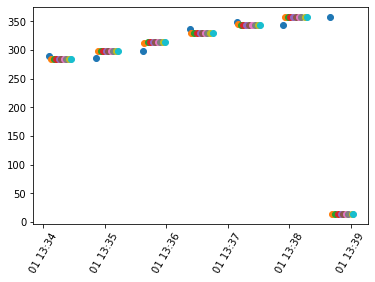

In [12]:
import datetime

for md in sea_img_metadata[:]:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['alta_yaw'])
    plt.xticks(rotation=60)

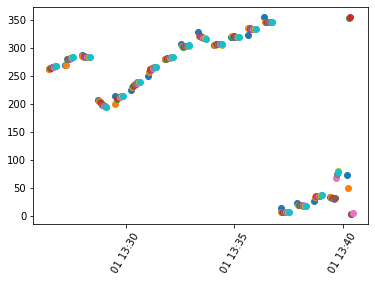

In [13]:
import datetime

for md in mds[:]:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['yaw'])
    plt.xticks(rotation=60)

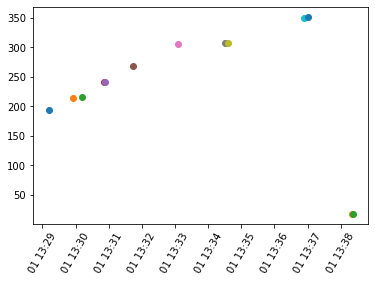

In [49]:
import datetime

for md in sky_img_metadata[2:]:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['yaw'])
    plt.xticks(rotation=60)

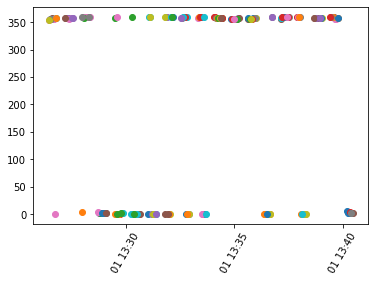

In [19]:
for md in mds:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['pitch'])
    plt.xticks(rotation=60)

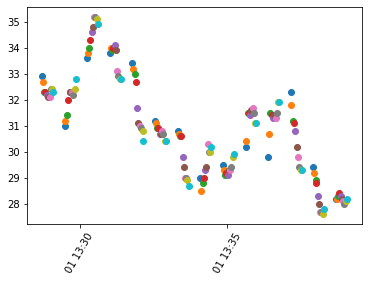

In [39]:
for md in mds[30:170]:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['Altitude'])
    plt.xticks(rotation=60)

In [13]:
sea_imgs.nbytes / 1e9

9.9475488

In [39]:
sky_imgs.nbytes / 1e9

NameError: name 'sky_imgs' is not defined

Inspect the bands either through time or sorted by pitch/yaw/lat/ etc

In [40]:
sea_img_md_pitch_sort = sorted(sea_img_metadata[1:], key=lambda k: k['pitch'])

In [ ]:
sky_img_md_pitch_sort = sorted(sky_img_metadata[2:], key=lambda k: k['pitch'])

In [46]:
.25 / math.pi

0.07957747154594767

In [75]:
plt.rcParams.update({'font.size': 12})

In [27]:
# yaws = [200, 215, 230, 245, 260, 275, 290]
yaws = [285, 300, 315, 330, 345, 360,375]

In [51]:
(np.array(yaws)-105)

array([180, 195, 210, 225, 240, 255, 270])

In [30]:
sea_img_metadata

[{'Latitude': 34.71496388888889,
  'Longitude': -76.67529722222223,
  'Altitude': 29,
  'UTC-Time': '13:34:5',
  'Date': '04/07/2021',
  'full_filename': 'data/20210407_duml_full_workflow_test/sea/stacks/AFbKZ4bKrkUTiZoewIOf.tif',
  'filename': 'AFbKZ4bKrkUTiZoewIOf.tif',
  'yaw': 305.76420896958706,
  'pitch': 358.36734353525856,
  'roll': 4.593105099204308,
  'id': 0,
  'log_id': 13686,
  'alta_yaw': 290.0,
  'image_name': 'data/20210407_duml_full_workflow_test/sea/IMG_0270_1.tif'},
 {'Latitude': 34.71496388888889,
  'Longitude': -76.67530000000001,
  'Altitude': 28.5,
  'UTC-Time': '13:34:7',
  'Date': '04/07/2021',
  'full_filename': 'data/20210407_duml_full_workflow_test/sea/stacks/4Bdn4cuirGgE7tXZGCze.tif',
  'filename': '4Bdn4cuirGgE7tXZGCze.tif',
  'yaw': 305.9434609053454,
  'pitch': 358.5202148128915,
  'roll': 5.2365807280075956,
  'id': 1,
  'log_id': 13737,
  'alta_yaw': 284.4,
  'image_name': 'data/20210407_duml_full_workflow_test/sea/IMG_0271_1.tif'},
 {'Latitude': 34.71

Calculate the 99% percentile of the data for visualization. We'll use the sun blocked measurements for the bottom range and the 99% percentile for the top.

In [77]:
np.percentile(sea_imgs[:,0,:,:].flatten(), [99])

array([0.01854412])

In [78]:
np.percentile(sea_imgs[:,1,:,:].flatten(), [99])

array([0.02162347])

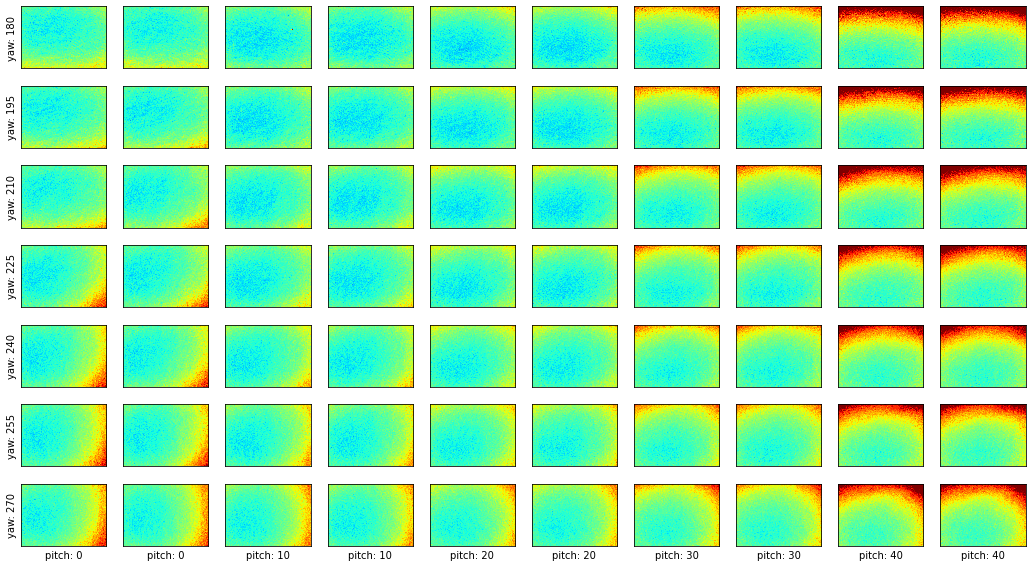

In [93]:
fig, ax = plt.subplots(7,10, figsize=(18,10))

for j in np.arange(0,70,10):
    for i in range(0,10):
        if j ==60:
            ax[int(j/10),i].set_xlabel('pitch: '+str(0+10*int(i/2)))
        if i == 0:
            ax[int(j/10),i].set_ylabel('yaw: ' + str(yaws[int(j/10)]-105))
#             pass
#         ax[int(j/10),i].set_title('yaw: ' + str(int(sea_img_metadata[i+j]['alta_yaw'])))
        im = ax[int(j/10),i].imshow(sea_imgs[i+j][0], interpolation='none',cmap='jet', vmin=0.0067, vmax=.0185)
        ax[int(j/10),i].set_xticks([])
        ax[int(j/10),i].set_yticks([])
fig.savefig('yaw_pitch_test_med_res_blue.png')
plt.show()


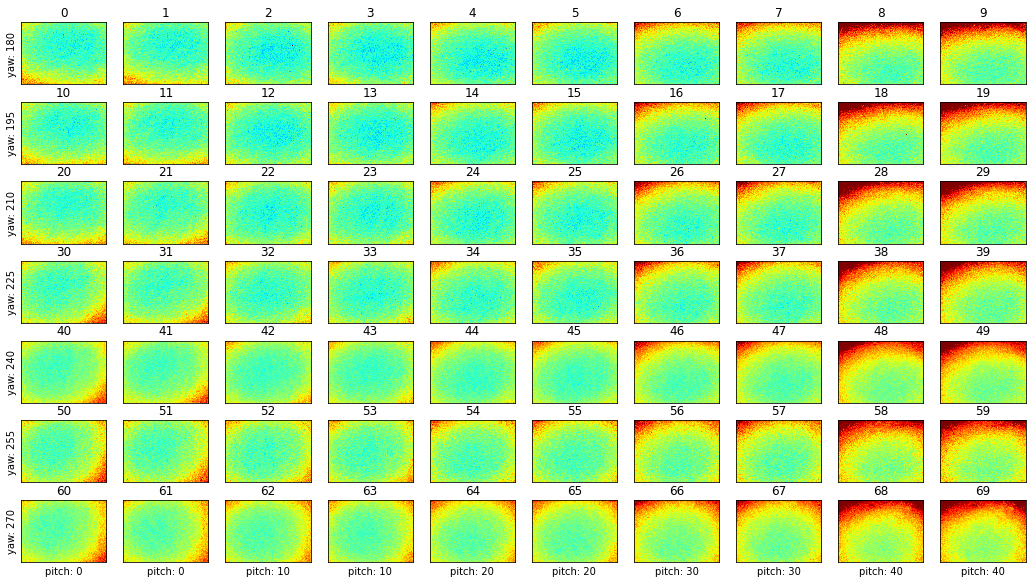

In [95]:
fig, ax = plt.subplots(7,10, figsize=(18,10))

for j in np.arange(0,70,10):
    for i in range(0,10):
        if j ==60:
            ax[int(j/10),i].set_xlabel('pitch: '+str(0+10*int(i/2)))
        if i == 0:
            ax[int(j/10),i].set_ylabel('yaw: ' + str(yaws[int(j/10)]-105))
        #ax[i].set_title('yaw: ' + str(int(sea_img_metadata[i+j]['alta_yaw']))+'\n pitch: '+str(0+10*int(i/2)))
        im = ax[int(j/10),i].imshow(sea_imgs[i+j][1], interpolation='none', 
                       cmap='jet', vmin=0.0106, vmax=.0216)
        ax[int(j/10),i].set_title(str(i+j))
        ax[int(j/10),i].set_xticks([])
        ax[int(j/10),i].set_yticks([])
# fig.savefig('yaw_pitch_test_med_res_green.png')
plt.show()

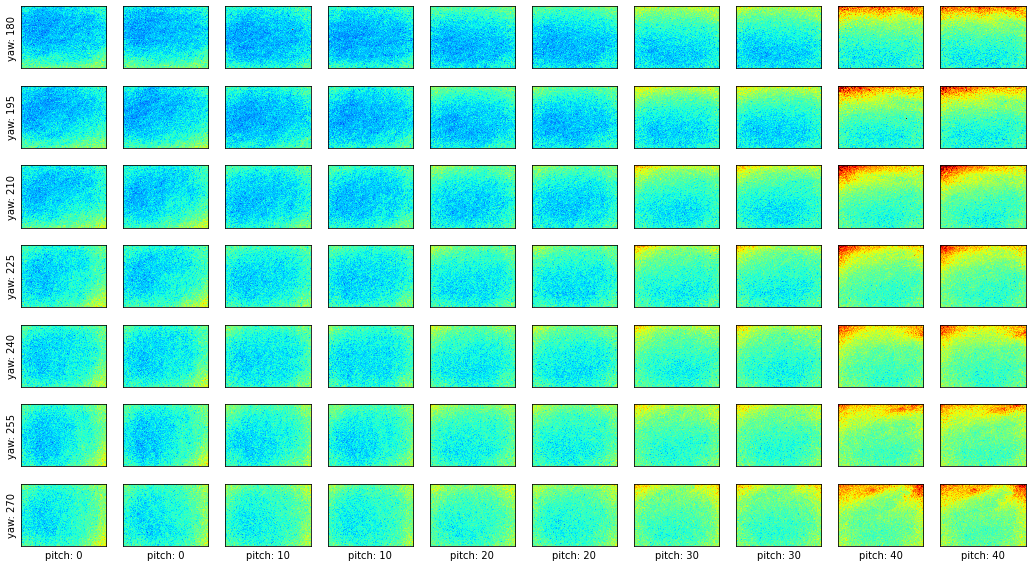

In [54]:
fig, ax = plt.subplots(7,10, figsize=(18,10))

for j in np.arange(0,70,10):
    for i in range(0,10):
        if j ==60:
            ax[int(j/10),i].set_xlabel('pitch: '+str(0+10*int(i/2)))
        if i == 0:
            ax[int(j/10),i].set_ylabel('yaw: ' + str(yaws[int(j/10)]-105))
        #ax[i].set_title('yaw: ' + str(int(sea_img_metadata[i+j]['alta_yaw']))+'\n pitch: '+str(0+10*int(i/2)))
        im = ax[int(j/10),i].imshow(sea_imgs[i+j][2], interpolation='none', 
                       cmap='jet', vmin=0.0047, vmax=.012)
        ax[int(j/10),i].set_xticks([])
        ax[int(j/10),i].set_yticks([])
# fig.savefig('yaw_pitch_test_med_res.png')
plt.show()

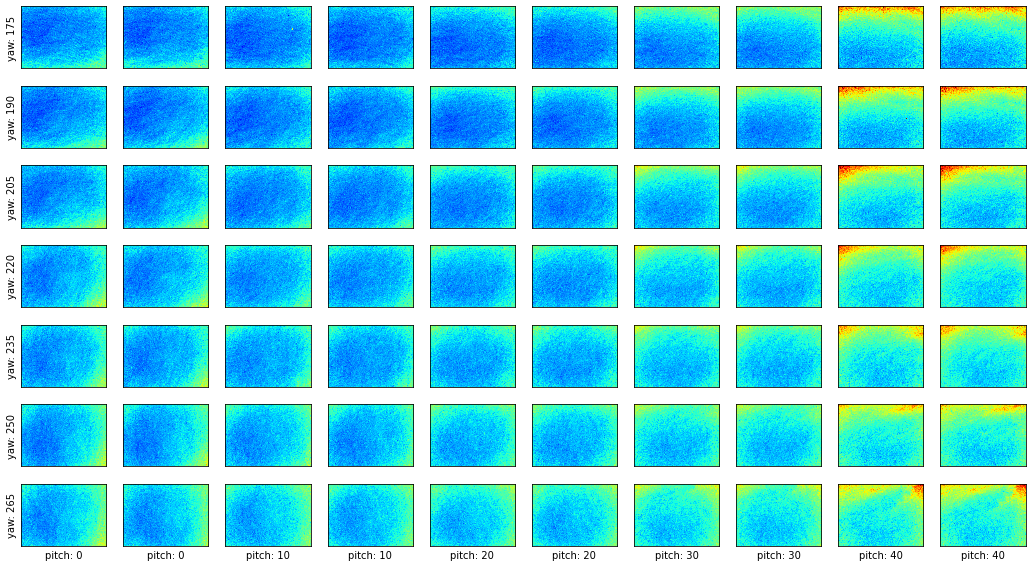

In [86]:
fig, ax = plt.subplots(7,10, figsize=(18,10))

for j in np.arange(0,70,10):
    for i in range(0,10):
        if j ==60:
            ax[int(j/10),i].set_xlabel('pitch: '+str(0+10*int(i/2)))
        if i == 0:
            ax[int(j/10),i].set_ylabel('yaw: ' + str(yaws[int(j/10)]-110))
        #ax[i].set_title('yaw: ' + str(int(sea_img_metadata[i+j]['alta_yaw']))+'\n pitch: '+str(0+10*int(i/2)))
        im = ax[int(j/10),i].imshow(sea_imgs[i+j][3], interpolation='none', 
                       cmap='jet', vmin=0.0022, vmax=.008)
        ax[int(j/10),i].set_xticks([])
        ax[int(j/10),i].set_yticks([])
# fig.savefig('yaw_pitch_test_med_res.png')
plt.show()

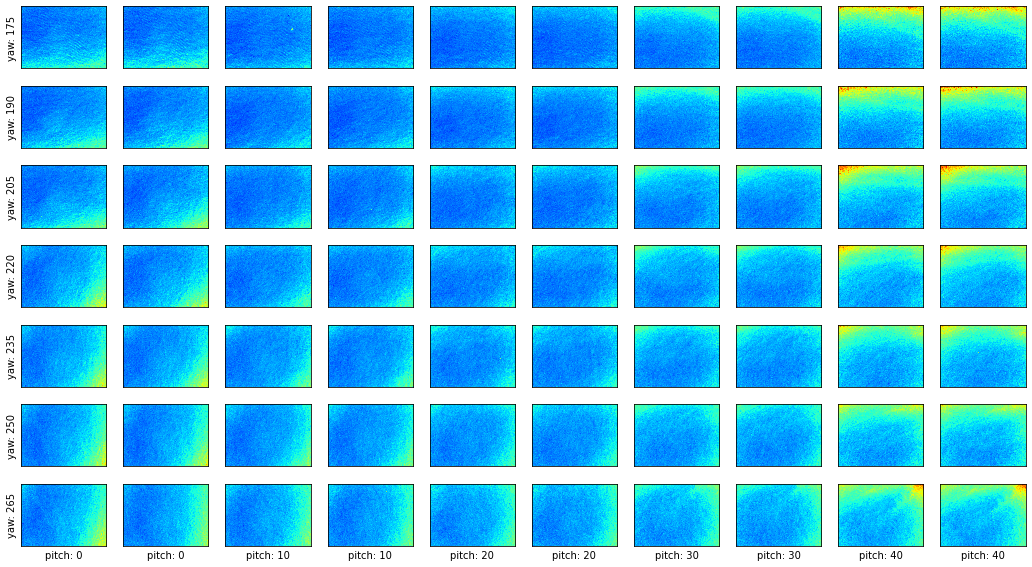

In [85]:
fig, ax = plt.subplots(7,10, figsize=(18,10))

for j in np.arange(0,70,10):
    for i in range(0,10):
        if j ==60:
            ax[int(j/10),i].set_xlabel('pitch: '+str(0+10*int(i/2)))
        if i == 0:
            ax[int(j/10),i].set_ylabel('yaw: ' + str(yaws[int(j/10)]-110))
        #ax[i].set_title('yaw: ' + str(int(sea_img_metadata[i+j]['alta_yaw']))+'\n pitch: '+str(0+10*int(i/2)))
        im = ax[int(j/10),i].imshow(sea_imgs[i+j][4], interpolation='none', 
                       cmap='jet', vmin=0.00044, vmax=.004)
        ax[int(j/10),i].set_xticks([])
        ax[int(j/10),i].set_yticks([])
# fig.savefig('yaw_pitch_test_med_res.png')
plt.show()

Inspect the radial averages of the images.

Inspect the images from top to bottom in 5 degree chunks in blue and green. Looking at images 38 and 39 because this is the recommended angle of 135 and 40 off nadir. Micasense viewing angle is 48º x 36.8º H x V.

In [97]:
sea_imgs[38,0,:,:].shape

(1470, 2014)

In [99]:
2014/48 * 10

419.58333333333337

In [101]:
2014 / 2 - 420/2

797.0

In [104]:
sea_imgs[38,0,:,797:-797].shape

(1470, 420)

In [105]:
36.8/12

3.0666666666666664

In [106]:
1470/12

122.5

In [120]:
list(range(1470,122,-122))

[1470, 1348, 1226, 1104, 982, 860, 738, 616, 494, 372, 250, 128]

In [179]:
sea_imgs[38,0].shape[0]

1470

In [328]:
img_num = 4 # 38,39

In [329]:
plt.rcParams.update({'font.size': 12})

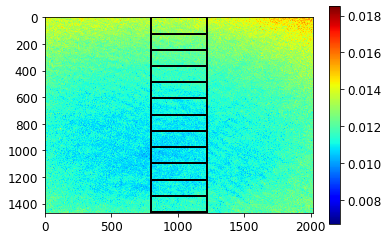

In [330]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
im= ax.imshow(sea_imgs[img_num,0], interpolation='none',cmap='jet', vmin=0.0067, vmax=.0185)
# sea_imgs[38,0,i-122:i,797:-797]
fig.colorbar(im)
# patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
# Create a Rectangle patch
# rect = patches.Rectangle((797, 0), 420, 1470, linewidth=3, edgecolor='grey', facecolor='none')
# # Add the patch to the Axes
# ax.add_patch(rect)

for i in range(0,1470,122):
    rect = patches.Rectangle((797, i), 420, 122, linewidth=2, edgecolor='black', facecolor='none', ls='-')
    # Add the patch to the Axes
    ax.add_patch(rect)

# fig.savefig('sections_for_vg_analysis.png')
plt.show()

In [331]:
list(range(1470,122,-122))

[1470, 1348, 1226, 1104, 982, 860, 738, 616, 494, 372, 250, 128]

In [332]:
blue_medians = []
green_medians = []
red_medians = []
nir_medians = []
re_medians = []
for i in range(1470,122,-122):
    blue_medians.append(np.median(sea_imgs[img_num,0,i-122:i,797:-797]))
    green_medians.append(np.median(sea_imgs[img_num,1,i-122:i,797:-797]))
    red_medians.append(np.median(sea_imgs[img_num,2,i-122:i,797:-797]))
    nir_medians.append(np.median(sea_imgs[img_num,3,i-122:i,797:-797]))
    re_medians.append(np.median(sea_imgs[img_num,4,i-122:i,797:-797]))

In [333]:
blue_medians = np.array(blue_medians)
green_medians = np.array(green_medians)
red_medians = np.array(red_medians)
nir_medians = np.array(nir_medians)
re_medians = np.array(re_medians)

In [334]:
degrees = np.arange(1.5,37.5,3)+40/2

In [335]:
degrees

array([21.5, 24.5, 27.5, 30.5, 33.5, 36.5, 39.5, 42.5, 45.5, 48.5, 51.5,
       54.5])

Text(0.5, 0, 'Degrees from Nadir')

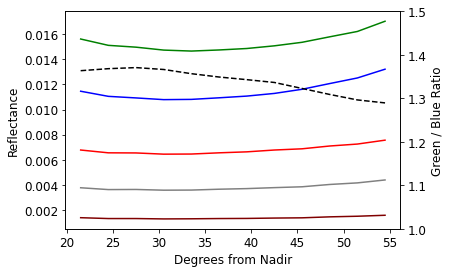

In [336]:
fig, ax = plt.subplots()
ax.plot(degrees,blue_medians, color='blue')
ax.plot(degrees,green_medians, color='green')
ax.plot(degrees,red_medians, color='red')
ax.plot(degrees,nir_medians, color='grey')
ax.plot(degrees,re_medians, color='maroon')

ax2 = ax.twinx()
ax.set_ylabel('Reflectance')
ax2.set_ylabel('Green / Blue Ratio')

ax2.plot(degrees,green_medians/blue_medians, color='black', ls='--')
# ax2.plot(red_medians/blue_medians, color='black')
ax2.set_ylim(1,1.5)
ax.set_xlabel('Degrees from Nadir')
# fig.savefig('spectral_changes_with_va.png',dpi=300)

### Now calculate some radial changes

In [337]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [338]:
sea_imgs[img_num, 0,:,:].shape

(1470, 2014)

In [319]:
img_num=38

In [339]:
blue_radial_medians = []
green_radial_medians = []
radiuses = list(range(50,750,50))
for i in radiuses:
    mask = create_circular_mask(1470, 2014, radius=i)
    blue_radial_medians.append(np.median(sea_imgs[img_num, 0,:,:][mask]))
    green_radial_medians.append(np.median(sea_imgs[img_num, 1,:,:][mask]))

In [340]:
blue_radial_medians = np.array(blue_radial_medians)
green_radial_medians = np.array(green_radial_medians)

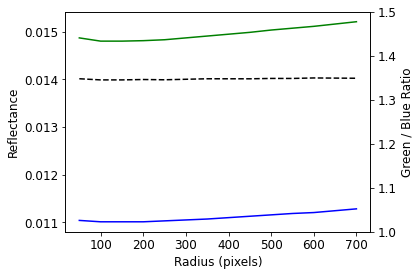

In [341]:
fig, ax = plt.subplots()
ax.plot(radiuses,blue_radial_medians,color='blue')
ax.plot(radiuses,green_radial_medians,color='green')

ax2 = ax.twinx()
ax2.plot(radiuses,green_radial_medians/blue_radial_medians,color='black', ls='--')

# ax.set_ylim(0.012,.017)
ax2.set_ylim(1,1.5)

# ax2.plot(blue_radial_medians, color='blue', alpha=0.3, ls='--')
# ax3 = ax.twinx()
# ax3.plot(green_radial_medians, color='green', alpha=0.3, ls='--')
# ax3.spines['right'].set_position(('outward', 70))
ax.set_ylabel('Reflectance')
ax.set_xlabel('Radius (pixels)')
ax2.set_ylabel('Green / Blue Ratio')
fig.tight_layout()
# fig.savefig('radial_changes.png')
plt.show()

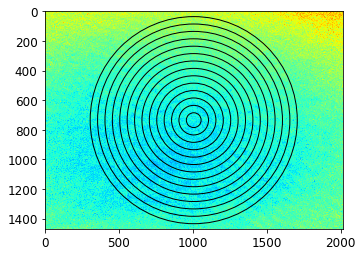

In [342]:
from matplotlib.patches import Circle
fig, ax = plt.subplots()
ax.imshow(sea_imgs[img_num,0], interpolation='none',cmap='jet', vmin=0.0067, vmax=.0185)

x,y = (int(2014/2), int(1470/2))

# Now, loop through coord arrays, and create a circle at each x,y pair
for i in radiuses:
    circ = Circle((x,y),radius=i, edgecolor='black', facecolor='none')
    ax.add_patch(circ)

# Show the image
# fig.savefig('radial_overlay.png')
plt.show()

### Now sky!

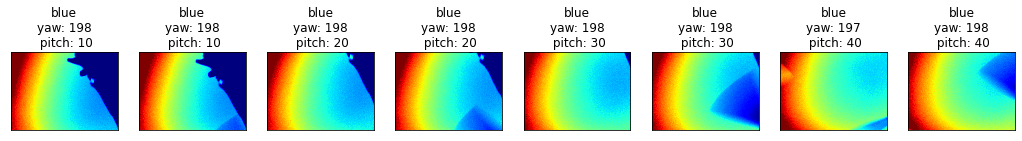

In [43]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+8*0]['alta_yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

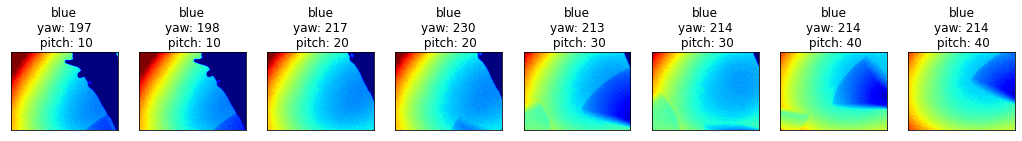

In [44]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+8*1]['alta_yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i+8][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

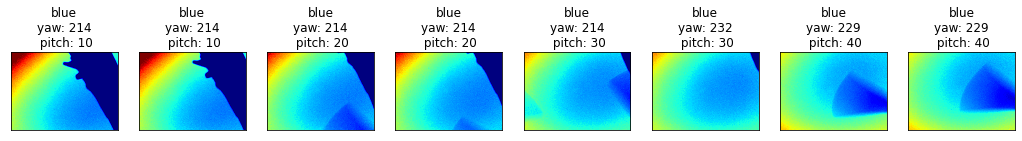

In [45]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    #ax[i].set_title('blue sky, yaw: ' + str(int(sky_img_metadata[i+8*2]['yaw'])))
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+8*2]['alta_yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i+8*2][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

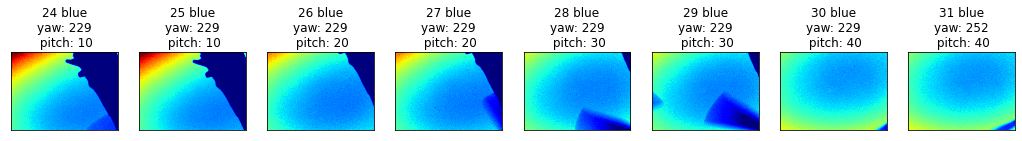

In [46]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title(str(i+8*3) + ' blue\nyaw: ' + str(int(sea_img_metadata[i+8*3]['alta_yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i+8*3][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

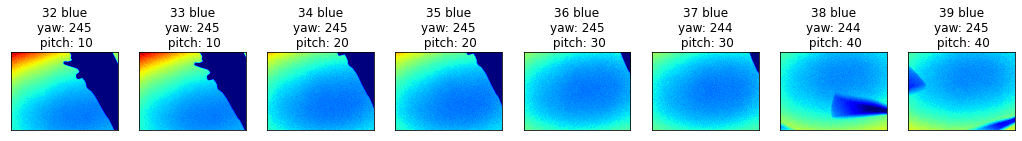

In [47]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title(str(i+8*4) + ' blue\nyaw: ' + str(int(sea_img_metadata[i+8*4]['alta_yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i+8*4][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

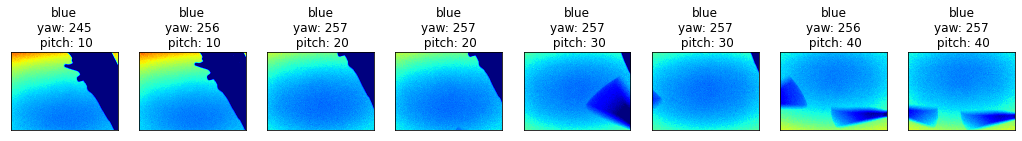

In [48]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+8*5]['alta_yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i+8*5][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

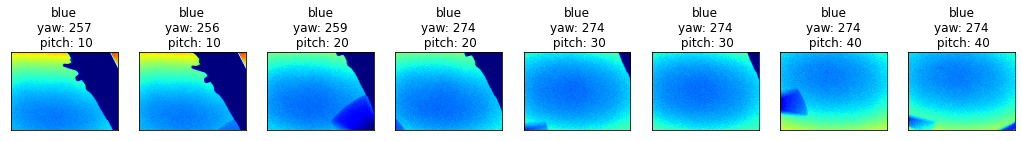

In [49]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+8*6]['alta_yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i+8*6][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

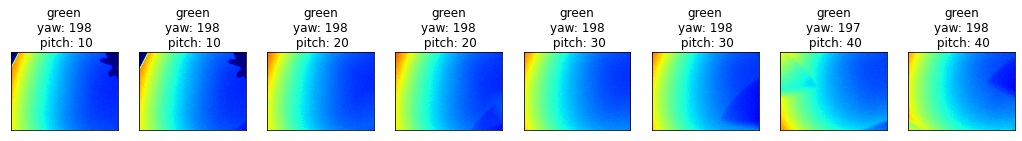

In [50]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('green\nyaw: ' + str(int(sea_img_metadata[i+8*0]['alta_yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i][1], interpolation='none', 
                   cmap='jet', vmin=0.05, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

#### inspect the sun blocked spectra based on the brightest pics there

In [41]:
blocked_imgs.shape

(7, 5, 946, 1267)

brightest pixels used: 599
brightest pixels used: 599
brightest pixels used: 599
brightest pixels used: 599
brightest pixels used: 599


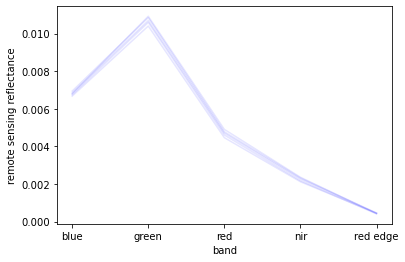

In [42]:
blocked_spectra = []
for i in range(0,5):
    spec = brightest_tube_pix(blocked_imgs[i], percent=0.0005)
    plt.plot(band_names, spec, color='blue', alpha=0.1)
    plt.ylabel('remote sensing reflectance')
    plt.xlabel('band')
    blocked_spectra.append(spec)
blocked_spectra = np.array(blocked_spectra)

In [82]:
np.median(blocked_spectra, axis=0)

array([0.00679944, 0.01068655, 0.00470179, 0.00225742, 0.00043846])

### Visualize some of the rededge data for the correction

In [138]:
sky_re_imgs.shape, sea_re_imgs.shape

((4, 5, 946, 1267), (9, 5, 946, 1267))

pitch 55.22378489978678
231.59169870567823
pitch 59.981352264989084
249.39674060544104


/home/clifgray/Code/ocean_color/utils.py:434: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


pitch 59.28543112523056
248.81318506371252
pitch 59.609122592910694
248.2294867305343
pitch 59.68638973056699
246.60952223247872
pitch 61.014638603875596
242.58189136495963
pitch 55.40071388953356
240.43571902219384
pitch 55.12979555593489
239.19015596776558


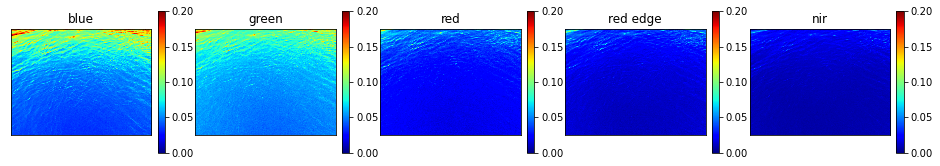

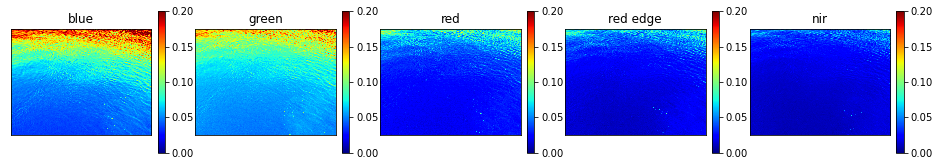

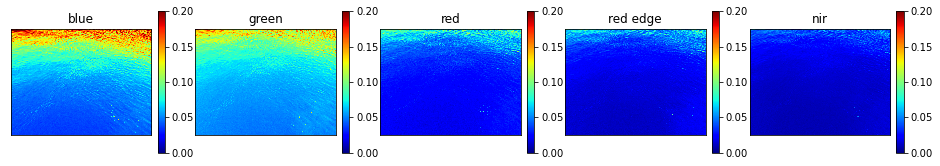

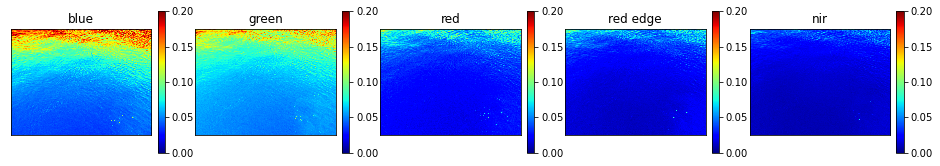

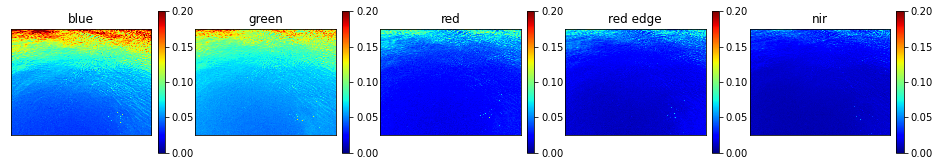

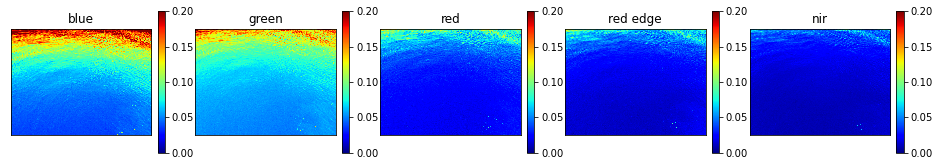

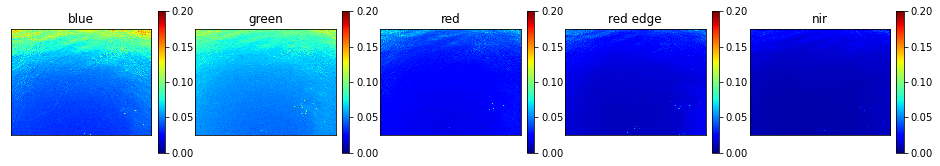

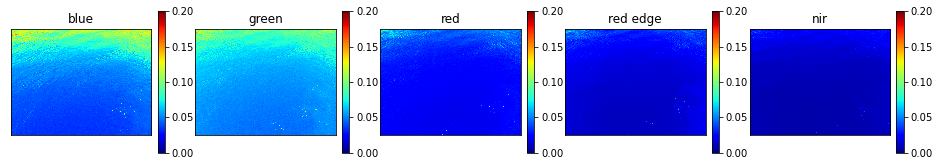

In [26]:
for i in range(0,8):
    print('pitch', sea_re_img_metadata[i]['pitch'])
    print(sea_re_img_metadata[i]['yaw'])
    visualize_darkest_pixels(sea_re_imgs[i], lowest_percent=1, max_clim=0.2, only_img=True)

pitch 37.24920074044252
57.145434939278175
pitch 39.40261551786597
54.71224316974633
pitch 45.63918681770838
53.38104661148208
pitch 42.59217228666313
56.883200578649564


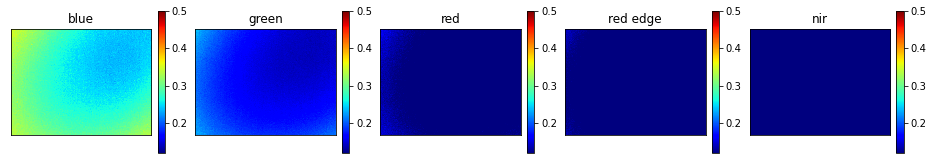

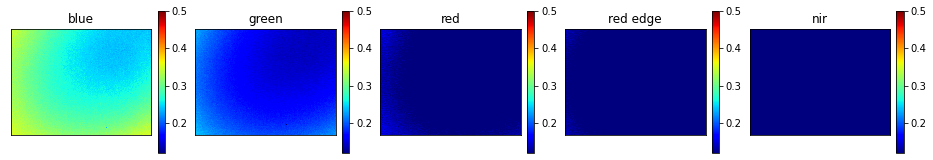

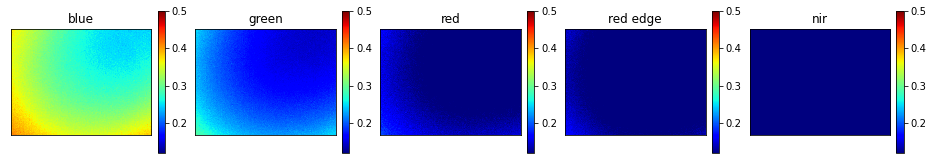

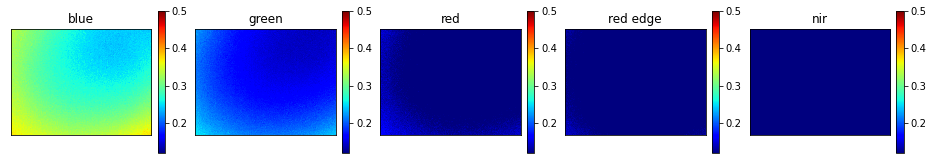

In [56]:
for i in range(0,4):
    print('pitch', sky_re_img_metadata[i]['pitch'])
    print(sky_re_img_metadata[i]['yaw'])
    visualize_darkest_pixels(sky_re_imgs[i], lowest_percent=1, min_clim=0.12, max_clim=0.5, only_img=True)

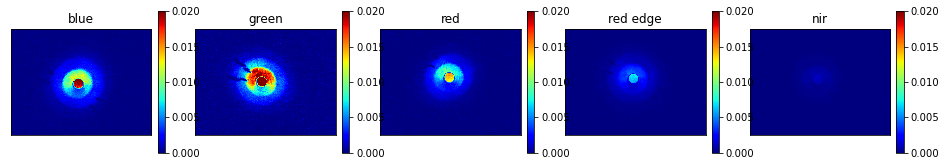

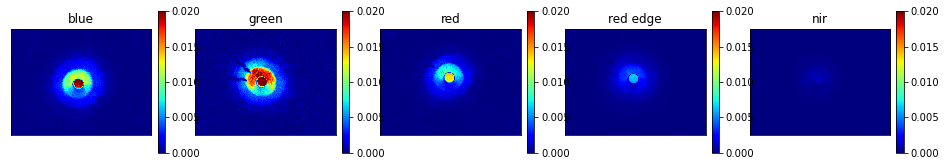

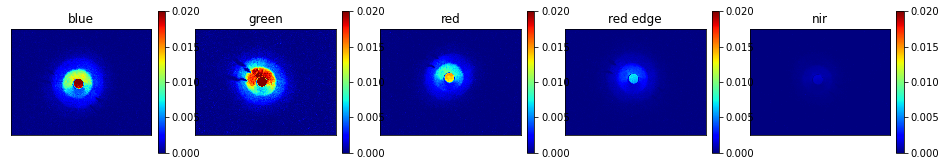

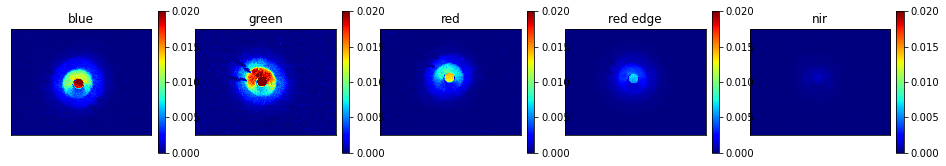

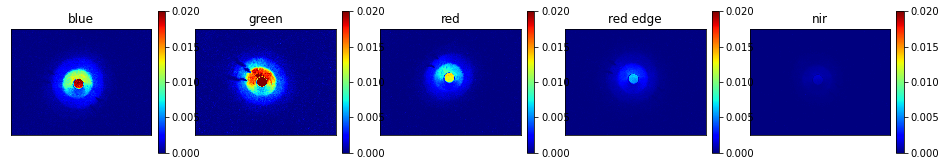

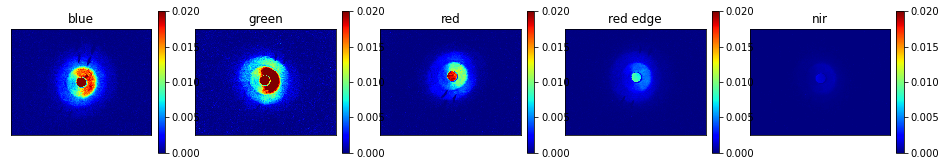

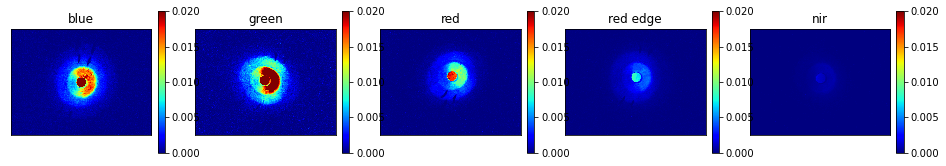

In [28]:
for i in range(0,7):
    visualize_darkest_pixels(blocked_imgs[i], lowest_percent=1, max_clim=0.02, only_img=True)

### Apply the sunblocked based approach

In [29]:
np.median(blocked_spectra,axis=0)

array([0.02212037, 0.03488749, 0.01545856, 0.00754759, 0.00149023])

#### Calculate rho by lt - lw / lsky

This is using the rededge images which seem to have some value mismatch and thus are off

(9, 5, 946, 1267)


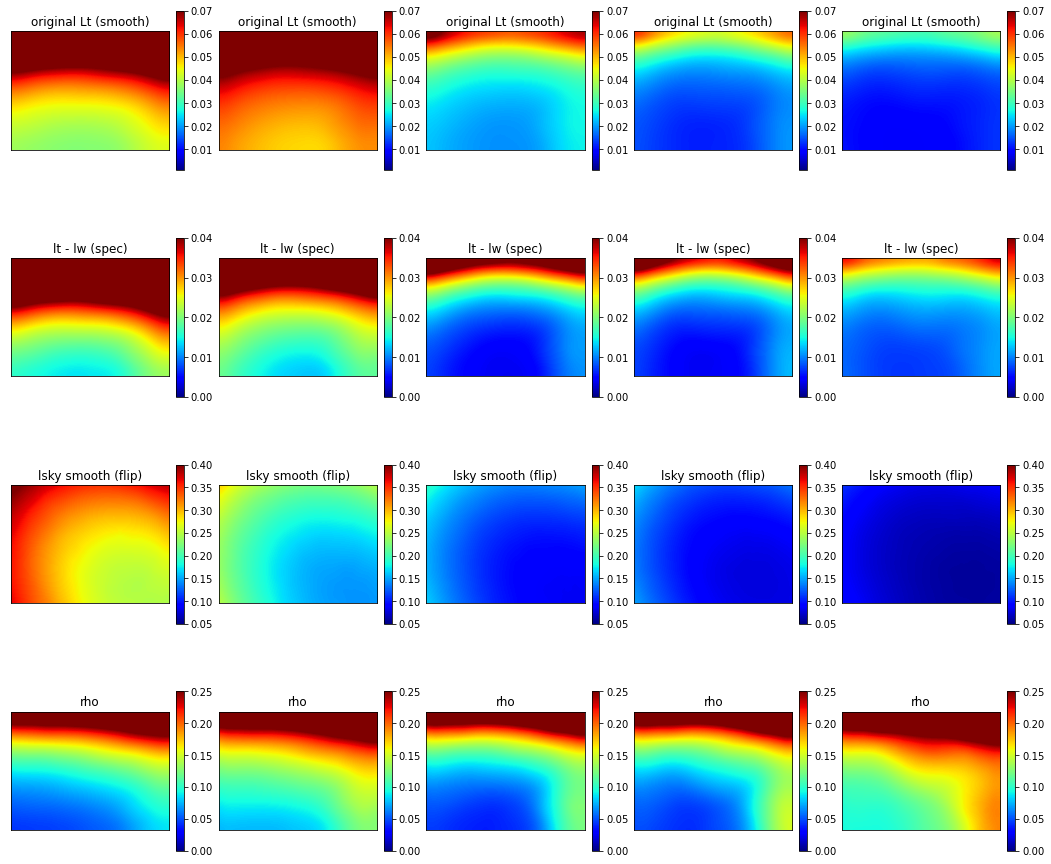

In [31]:
rho = calculate_rho(sea_re_imgs, 
              sky_re_imgs[2][np.newaxis,...], 
              np.median(blocked_spectra,axis=0), visualize=True)

Now using the images from the drone only

(1, 5, 1470, 2014)


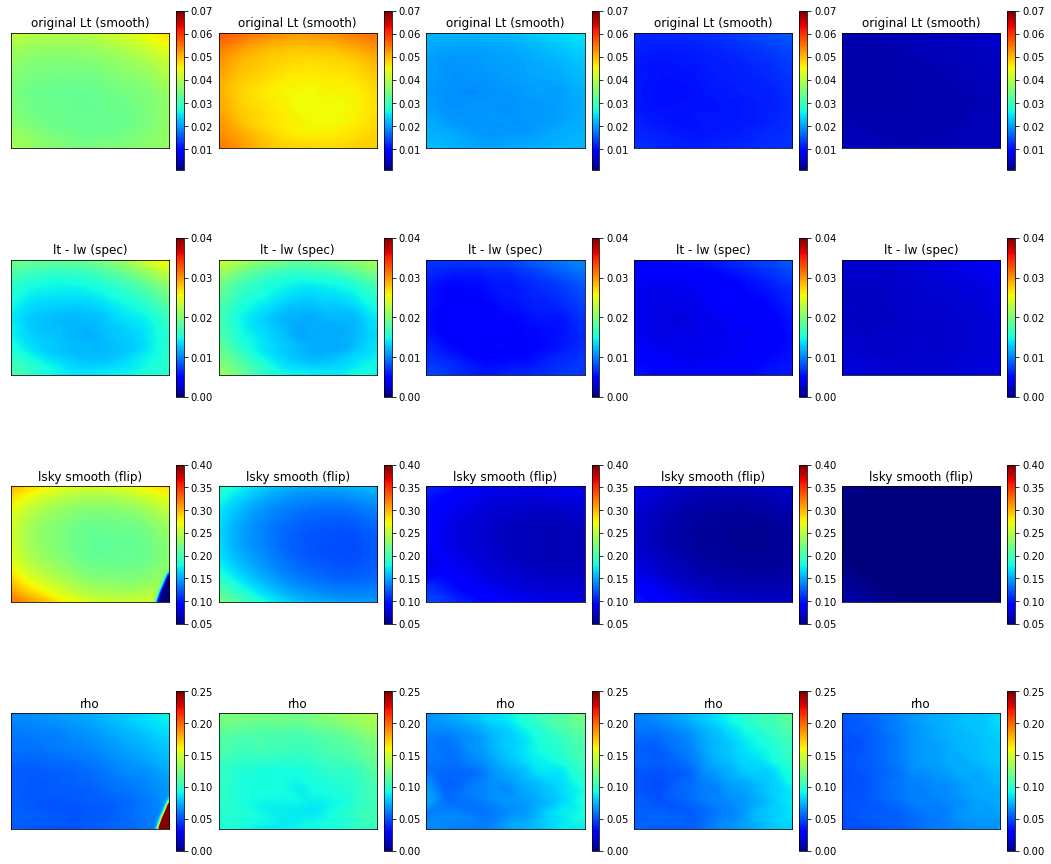

In [20]:
# trying it at the 20 degree off nadir image
rho = calculate_rho(sea_imgs[35,:5][np.newaxis,...], 
              sky_imgs[37,:5][np.newaxis,...], 
              np.median(blocked_spectra,axis=0), visualize=True)

(1, 5, 1470, 2014)


/home/clifgray/Code/ocean_color/utils.py:653: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


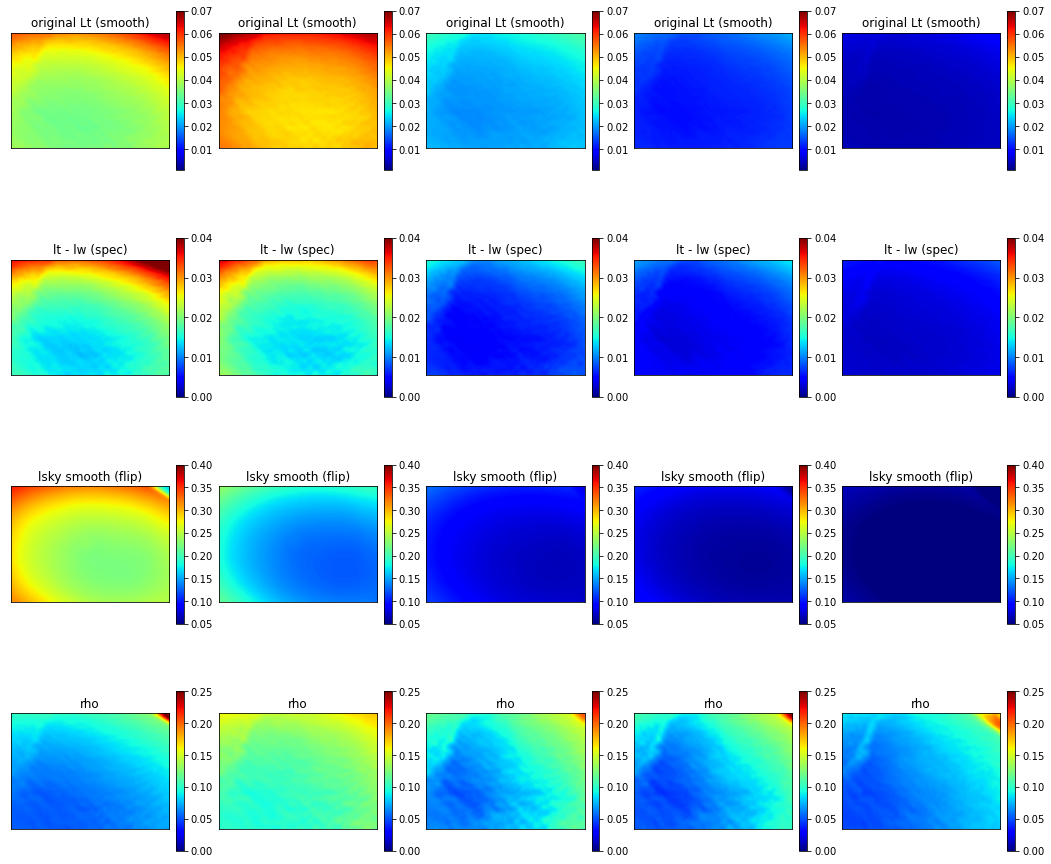

In [52]:
# this is at 135 and 40
rho = calculate_rho(sea_imgs[28,:5][np.newaxis,...], 
              sky_imgs[30,:5][np.newaxis,...], 
              np.median(blocked_spectra,axis=0), visualize=True)

(5, 1470, 2014)


/home/clifgray/Code/ocean_color/utils.py:708: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


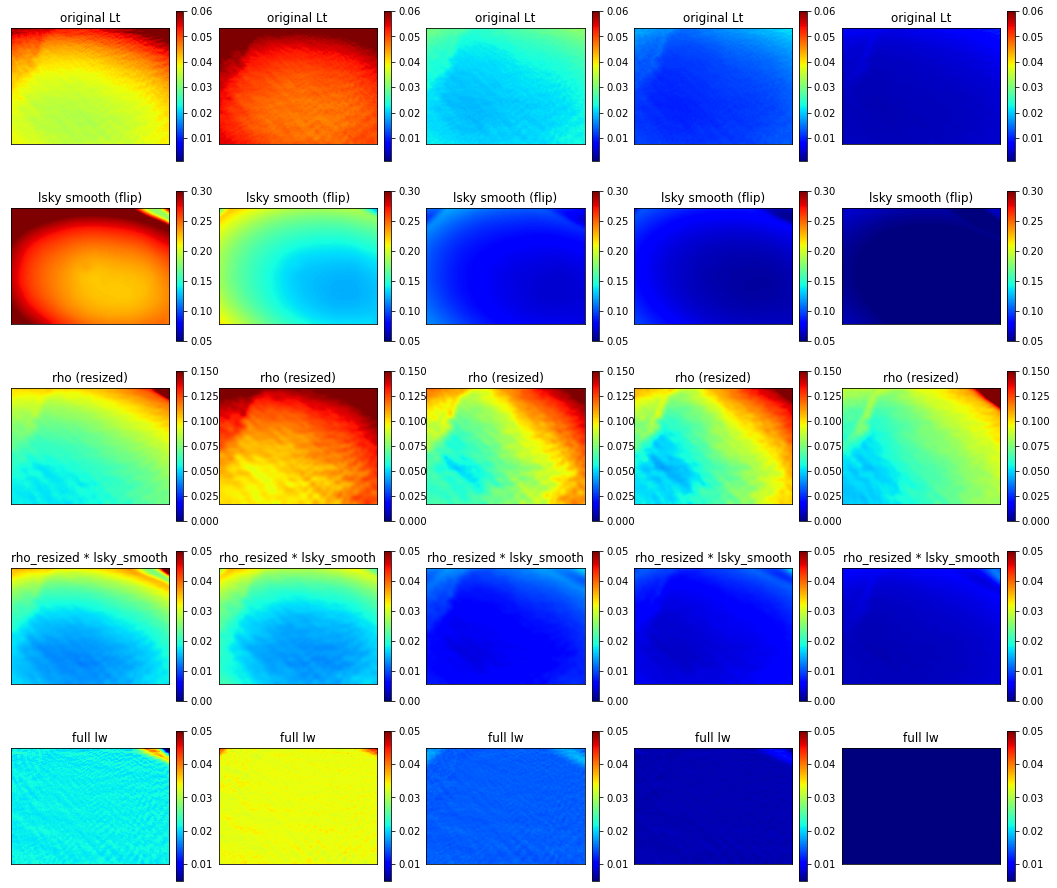

In [53]:
lw_processed = apply_rho(sea_imgs[29,:5], 
              sky_imgs[31,:5], rho, visualize=True)

#### Inspect the spectra from this

In [6]:
fig, ax = plt.subplots(figsize=(13,10))

for spectra in [np.median(sea_imgs[sea_img_md_pitch_sort[7]['id']],axis=(1,2))]:
    ax.plot(band_names, spectra, color='blue', alpha=0.5)
    
for spectra in [np.median(lw_processed,axis=(1,2))]:
    ax.plot(band_names, spectra, color='green', alpha=0.5)

for spectra in blocked_spectra:
    ax.plot(band_names, spectra, color='pink', alpha=0.5)
    
for spectra in [np.median(sky_imgs[sky_img_md_pitch_sort[3]['id']],axis=(1,2))]:
    ax.plot(band_names, spectra, color='lightblue', alpha=0.7)
    
#ax.plot(band_names, np.median(sky_spectra[0], axis=0), color='grey')
#ax.plot(seaimgset.captures[capture_num].band_names_lower(), [0.13079345, 0.08020303, 0.05103283, 0.04054285, 0.04573154])

NameError: name 'plt' is not defined

#### What does chla look like from these images

In [61]:
chla_lw = vec_chla_img(lw_processed[0]-lw_processed[4], lw_processed[1]-lw_processed[4])

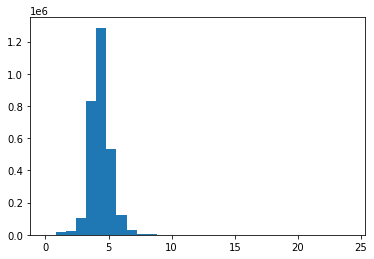

In [62]:
plt.hist(chla_lw.flatten(), bins=30)
plt.show()

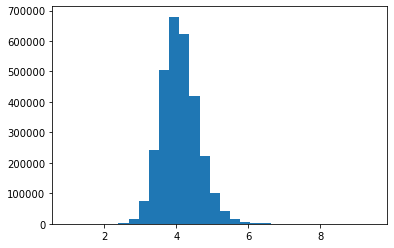

In [30]:
plt.hist(chla_lw.flatten(), bins=30)
plt.show()

In [24]:
chla_lw[300:, 100:-100].shape

(1170, 1814)

In [57]:
np.nanmedian(chla_lw)

4.065873429901383

In [26]:
np.median(chla_lw[300:, 100:-100])

4.070752121352445

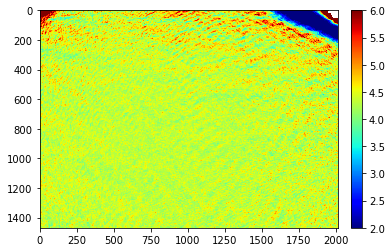

In [63]:
fig,ax = plt.subplots()
im = ax.imshow(chla_lw, cmap='jet', vmin=2,vmax=6)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

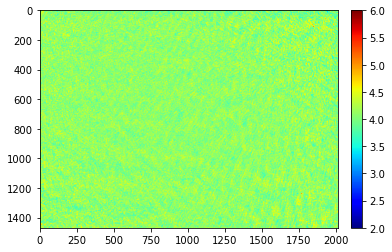

In [31]:
fig,ax = plt.subplots()
im = ax.imshow(chla_lw, cmap='jet', vmin=2,vmax=6)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

In [32]:
chla_lw.shape

(1470, 2014)

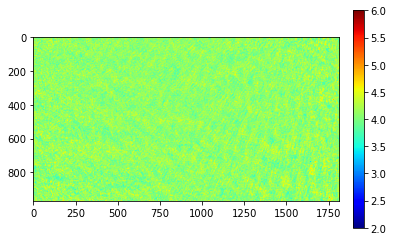

In [33]:
fig,ax = plt.subplots()
im = ax.imshow(chla_lw[500:, 100:-100], cmap='jet', vmin=2,vmax=6)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

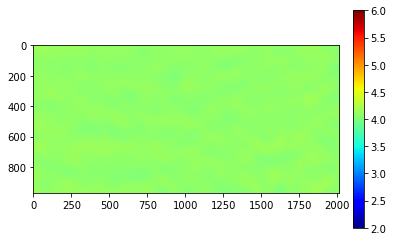

In [34]:
fig,ax = plt.subplots()
im = ax.imshow(ndimage.gaussian_filter(chla_lw[500:, :], sigma=(30, 30), order=0), cmap='jet', vmin=2,vmax=6)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

#### Now visualize a bunch of images and the chla from them

### Chlorophyll retrieval algorithm

Run chla retrieval on water leaving spectra

In [66]:
chla_list = []
for spectra in blocked_spectra:
    chla = L2chlor_a(spectra[0],spectra[0],spectra[1],spectra[1],spectra[2])
    chla_list.append(chla)
chla_list

[6.356087606017864,
 6.258882462214956,
 6.555905398674276,
 6.437045009156115,
 6.0705909634053805,
 6.0467082739748275,
 6.1363390346805025]

In [67]:
chla_list = []
for spectra in water_leaving_spec:
    chla = L2chlor_a(spectra[0],spectra[0],spectra[1],spectra[1],spectra[2])
    chla_list.append(chla)
chla_list

[3.725178152219733]

In [294]:
4.50674749003831 / 3.778

1.1928924007512731

In [68]:
for md in sea_img_metadata[:]:
    print(md['pitch'])

24.48100439092184
18.278774752899437
16.62868657249811
30.335922246084635
34.914430565022315
37.5013787624174
34.73575007534288
45.9768427574661
51.218735490343306
57.236565622612886
52.02441024442453
46.67323453974166
42.0941159243867
37.69342367764301
29.24397755315249
49.92532694279146


### Save spectra and chla values as a geopandas dataframe along with image metadata

In [69]:
# TODO need to filter out for bad lat and lon and bad chl values
# it seems like sometimes lat and long are 0

In [ ]:
gdf = convert_to_ocean_color_gdf(chla_list, water_leaving_spec, [sea_img_metadata[i] for i in sea_idxs])
print(len(gdf))
gdf.head()

In [ ]:
import contextily as ctx
gdf.set_crs(epsg=4326, inplace=True)
web_merc_gdf = gdf.to_crs(epsg=3857)
fig,ax = plt.subplots(figsize=(12,12))
web_merc_gdf.plot(ax=ax, column='chla', vmax=6, vmin=3)
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.plot(ax=ax)
ctx.add_basemap(ax, zoom=12)
ax.set_ylim(4123102,4126102)
ax.set_xlim(-8537315, -8532315)

Save out the file

In [185]:
gdf.time = gdf.time.astype(str)
gdf.spectra = gdf.spectra.astype(str)
#gdf.to_file('data/260920_shearwateroffshore_dual/uas_data_260920_1_dark.shp')